In [1]:

import matplotlib as mpl
import argparse
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from utils.storage import DLStorageIterator, STAGE
from utils.preprocessing import BasicPreprocessor, Preprocessed
import numpy as np
import mneflow as mf
from utils.models import SimpleNet
import tensorflow as tf
import pandas as pd
from time import perf_counter
from deepmeg.params import save_parameters, compute_temporal_parameters, compute_waveforms, \
    Predictions, WaveForms, TemporalParameters, SpatialParameters, ComponentsOrder, get_order
import re
import logging
from utils import balance
from sklearn.preprocessing import StandardScaler

2022-12-14 12:28:14.936752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 12:28:15.299947: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-14 12:28:15.299977: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-14 12:28:16.556291: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
from tensorflow.keras import layers
from mneflow.layers import LFTConv, DeMixing, Dense
from tensorflow.keras.layers import Dropout

class SimpleNetT(SimpleNet):
    def __init__(self, Dataset, specs=None):
        if specs is None:
            specs=dict()
        super().__init__(Dataset, specs)

    def transformer_encoder_block(self, inputs):
        # Normalization and Attention
        x = layers.LayerNormalization(epsilon=1e-6)(inputs)
        x = layers.MultiHeadAttention(
            key_dim=self.specs['transformer_params']['head_size'],
            num_heads=self.specs['transformer_params']['num_heads'],
            dropout=self.specs['transformer_params']['dropout']
        )(x, x)
        x = layers.Dropout(self.specs['transformer_params']['dropout'])(x)
        res = x + inputs

        # Feed Forward Part
        x = layers.LayerNormalization(epsilon=1e-6)(res)
        x = layers.Conv1D(filters=self.specs['transformer_params']['ff_dim'], kernel_size=1, activation="relu")(x)
        x = layers.Dropout(self.specs['transformer_params']['dropout'])(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

        return x + res

    def build_graph(self):
        self.dmx = DeMixing(size=self.specs['n_latent'], nonlin=tf.identity,
                            axis=3, specs=self.specs)
        self.dmx_out = self.dmx(self.inputs)

        self.tconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=self.specs['nonlin'],
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )
        self.tconv_out = self.tconv(self.dmx_out)

        self.envconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=self.specs['nonlin'],
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )

        self.envconv_out = self.envconv(self.tconv_out)
        self.pool = lambda X: X[:, :, ::self.specs['pooling'], :]

        self.pooled = self.pool(self.envconv_out)

        dropout = Dropout(
            self.specs['dropout'],
            noise_shape=None
        )(self.pooled)

        x = dropout

        for _ in range(self.specs['transformer_params']['num_transformer_blocks']):
            x = self.transformer_encoder_block(x)
        x = layers.GlobalAveragePooling1D(data_format="channels_first")(tf.squeeze(x, axis=1))
        for dim in self.specs['transformer_params']['mlp_units']:
            x = layers.Dense(dim, activation="relu")(x)
            x = layers.Dropout(self.specs['transformer_params']['mlp_dropout'])(x)

        self.fin_fc = Dense(size=self.out_dim, nonlin=tf.identity,
                            specs=self.specs)
        y_pred = self.fin_fc(dropout)

        return y_pred

In [2]:
project_name = 'Coords_prediction'
subjects_dir = '../DATA'
classification_name_formatted = '16_branches_coords_prediction'

iterator = DLStorageIterator(subjects_dir, name=classification_name_formatted)

In [3]:
next(iterator)

'subj02'

In [39]:
sp_preprocessor = BasicPreprocessor(103, 200)
con_preprocessor = BasicPreprocessor(103, 200, 2)
sp_data_pre: Preprocessed = sp_preprocessor(iterator.get_data(STAGE.PRETEST))
sp_data_post: Preprocessed  = sp_preprocessor(iterator.get_data(STAGE.POSTTEST))
con_data_pre: Preprocessed = con_preprocessor(iterator.get_data(STAGE.PRETEST))
con_data_post: Preprocessed  = con_preprocessor(iterator.get_data(STAGE.POSTTEST))
epochs = sp_data_pre.epochs
X = np.concatenate([
    # epochs.pick_types(meg='grad').get_data(),
    # sp_data_post.epochs.pick_types(meg='grad').get_data(),
    con_data_pre.epochs.pick_types(meg='grad').get_data(),
    con_data_post.epochs.pick_types(meg='grad').get_data()
])

Reading /home/user/Projects/NeuralGeometry/dirty_field/../DATA/subj02/PreTest/PreTest_epochs_sel.fif ...


/home/user/Projects/NeuralGeometry/utils/storage.py:42: RuntimeWarning: This filename (../DATA/subj02/PreTest/PreTest_epochs_sel.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  return mne.read_epochs(self.epochs_path)


    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
890 matching events found
No baseline correction applied
0 projection items activated
Reading /home/user/Projects/NeuralGeometry/dirty_field/../DATA/subj02/PostTest/PostTest_epochs_sel.fif ...


/home/user/Projects/NeuralGeometry/utils/storage.py:42: RuntimeWarning: This filename (../DATA/subj02/PostTest/PostTest_epochs_sel.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  return mne.read_epochs(self.epochs_path)


    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
889 matching events found
No baseline correction applied
0 projection items activated
Reading /home/user/Projects/NeuralGeometry/dirty_field/../DATA/subj02/PreTest/PreTest_epochs_sel.fif ...


/home/user/Projects/NeuralGeometry/utils/storage.py:42: RuntimeWarning: This filename (../DATA/subj02/PreTest/PreTest_epochs_sel.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  return mne.read_epochs(self.epochs_path)


    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
890 matching events found
No baseline correction applied
0 projection items activated
Reading /home/user/Projects/NeuralGeometry/dirty_field/../DATA/subj02/PostTest/PostTest_epochs_sel.fif ...


/home/user/Projects/NeuralGeometry/utils/storage.py:42: RuntimeWarning: This filename (../DATA/subj02/PostTest/PostTest_epochs_sel.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  return mne.read_epochs(self.epochs_path)


    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
889 matching events found
No baseline correction applied
0 projection items activated


In [40]:
X.shape

(429, 204, 240)

In [41]:
Y = np.concatenate([
    # sp_data_pre.coordinates,
    # sp_data_post.coordinates,
    con_data_pre.coordinates,
    con_data_post.coordinates
])
# Y = StandardScaler().fit_transform(Y)
Y = np.around(Y/20, decimals=0)

In [42]:
Y.max()

2.0

In [43]:
A = np.reshape(np.arange(16), (4, 4))
Y_ind = np.array([
    A[int(y[0]), int(y[1])]
    for y in Y
    # for y in np.around(Y/20, decimals=0)
])

In [44]:
classes, classes_samples = np.unique(Y_ind, return_counts=True)

In [45]:
classes_samples

array([ 62,  15,  31,  16,  30,  16,  31,  16, 167,  31,  14])

In [46]:
classes

array([ 0,  1,  2,  3,  4,  5,  6,  8, 10, 12, 14])

In [47]:
X.shape

(429, 204, 240)

In [48]:
cond = np.append(np.where(Y_ind == 0), np.where(Y_ind == 10)[:122]).tolist()

X = X[cond, :, :]
Y = Y[cond, :]

In [ ]:
X, Y = balance(X, Y)

In [49]:
Y.shape

(229, 2)

In [50]:
import_opt = dict(
    savepath='../TFR/',  # path where TFR files will be saved
    out_name=project_name,  # name of TFRecords files
    fs=200,
    input_type='trials',
    target_type='float',
    picks={'meg':'grad'},
    scale=True,  # apply baseline_scaling
    crop_baseline=True,  # remove baseline interval after scaling
    decimate=None,
    scale_interval=(0, 40),  # indices in time axis corresponding to baseline interval
    n_folds=5,  # validation set size set to 20% of all data
    overwrite=True,
    segment=False,
    test_set='holdout'
)

meta = mf.produce_tfrecords((X, Y), **import_opt)
dataset = mf.Dataset(meta, train_batch=100)

importing from tuple
input shapes: X: (229, 204, 240) targets: (229, 2)
(229, 2)
Preprocessing:
Scaling to interval 0.0 - 40.0
n: 229
Splitting into: 6 folds x 38
Preprocessed: (229, 1, 200, 204) (229, 2) folds: 6 x 38
Prepocessed sample shape: (1, 200, 204)
Target shape actual/metadata:  (2,) (2,)
Saving TFRecord# 0


In [51]:
lf_params = dict(
    n_latent=16, #number of latent factors
    filter_length=50, #convolutional filter length in time samples
    nonlin = tf.nn.elu,
    padding = 'SAME',
    pooling = 5,#pooling factor
    stride = 5, #stride parameter for pooling layer
    pool_type='max',
    model_path = import_opt['savepath'],
    dropout = .4,
    l1_scope = ["weights"],
    l1_lambda=3e-3,
    # l2_scope = ["weights"],
    # l2_lambda=3e-3,
    transformer_params = dict(
        head_size=256,
        num_heads=4,
        ff_dim=4,
        num_transformer_blocks=10,
        mlp_units=[128],
        mlp_dropout=0.4,
        dropout=0.25,
    )
)
model = SimpleNet(dataset, lf_params)
model.build(
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=tf.keras.metrics.MeanAbsoluteError()
)

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 200, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 200, 16)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 200, 16)
Setting reg for fc, to l1
Built: fc input: (None, 1, 40, 16)
Input shape: (1, 200, 204)
y_pred: (None, 2)
Initialization complete!


In [52]:
model.train(
    n_epochs=25,
    eval_step=100,
    early_stopping=5
)

Class weights:  None
Epoch 1/25
100/100 - 3s - loss: 2.4763 - mean_absolute_error: 1.3253 - val_loss: 2.5641 - val_mean_absolute_error: 1.4865 - 3s/epoch - 26ms/step
Epoch 2/25
100/100 - 2s - loss: 2.0135 - mean_absolute_error: 0.9860 - val_loss: 2.4772 - val_mean_absolute_error: 1.4978 - 2s/epoch - 17ms/step
Epoch 3/25
100/100 - 2s - loss: 1.6878 - mean_absolute_error: 0.7525 - val_loss: 2.3868 - val_mean_absolute_error: 1.4949 - 2s/epoch - 16ms/step
Epoch 4/25
100/100 - 2s - loss: 1.4948 - mean_absolute_error: 0.6401 - val_loss: 2.3111 - val_mean_absolute_error: 1.4930 - 2s/epoch - 17ms/step
Epoch 5/25
100/100 - 2s - loss: 1.3475 - mean_absolute_error: 0.5618 - val_loss: 2.2191 - val_mean_absolute_error: 1.4650 - 2s/epoch - 17ms/step
Epoch 6/25
100/100 - 2s - loss: 1.2410 - mean_absolute_error: 0.5133 - val_loss: 2.1586 - val_mean_absolute_error: 1.4559 - 2s/epoch - 16ms/step
Epoch 7/25
100/100 - 2s - loss: 1.1573 - mean_absolute_error: 0.4765 - val_loss: 2.1086 - val_mean_absolute_e

In [53]:
train_loss_, train_acc_ = model.evaluate(meta['train_paths'])
test_loss_, test_acc_ = model.evaluate(meta['test_paths'])
train_acc_, test_acc_

(0.6045178771018982, 1.7436679601669312)

In [35]:
y_true_train, y_pred_train = model.predict(meta['train_paths'])
y_true_test, y_pred_test = model.predict(meta['test_paths'])

2/2 [==============================] - 0s 3ms/step


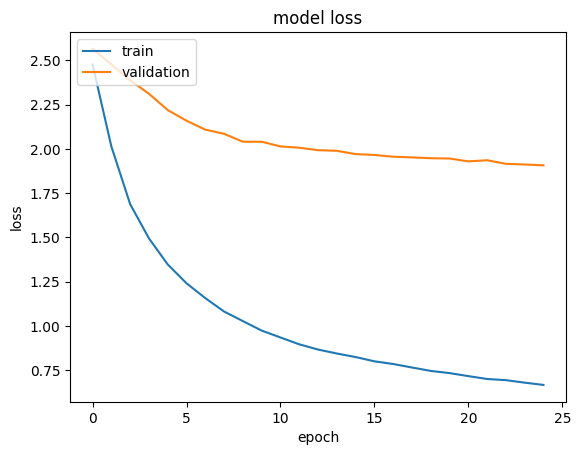

In [54]:
model.plot_hist()

In [56]:
model.compute_patterns()

Computing patterns: No path specified, using validation dataset (Default)


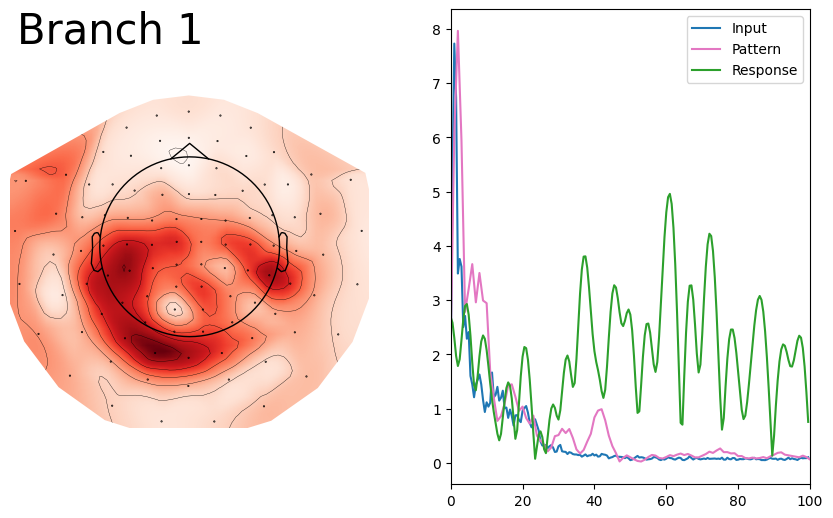

In [58]:
fig = model.plot_branch(1, epochs.pick_types(meg='grad').info, params=['input', 'pattern', 'response'])